# FloodSense South Sudan: Machine Learning-Based Flood Prediction and Early Warning System

This project implements an advanced flood prediction system specifically designed for South Sudan's unique environmental conditions. The system combines machine learning with domain expertise to provide accurate flood risk assessments and early warnings.

In [13]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                            roc_auc_score, accuracy_score)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import joblib
import os
import shutil
from IPython.display import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from faker import Faker
import random
import pickle
from sklearn.inspection import permutation_importance

In [14]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

In [18]:
# =============================================
# 1. Load and Save Original Dataset
# =============================================
print("\n=== 1. Loading and Saving Original Dataset ===")
def load_and_save_original(file_path):
    # Load dataset
    data = pd.read_csv('data/flood.csv')

    # Save original
    original_path = 'data/flood_original.csv'
    data.to_csv(original_path, index=False)
    print(f"Original dataset saved to {original_path}")

    return data

file_path = 'data/flood.csv'
original_data = load_and_save_original(file_path)


=== 1. Loading and Saving Original Dataset ===
Original dataset saved to data/flood_original.csv



=== 2. Exploring Original Dataset ===

Original Dataset Overview:
Shape: (50000, 21)

First 5 rows:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475



Missing Values:
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64


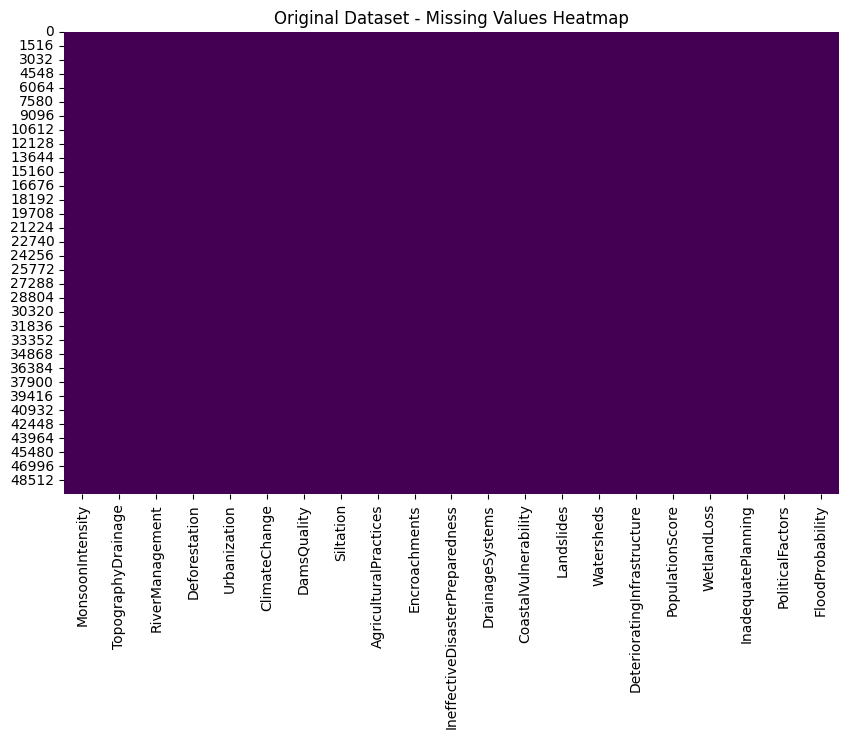


Data Types:
MonsoonIntensity                     int64
TopographyDrainage                   int64
RiverManagement                      int64
Deforestation                        int64
Urbanization                         int64
ClimateChange                        int64
DamsQuality                          int64
Siltation                            int64
AgriculturalPractices                int64
Encroachments                        int64
IneffectiveDisasterPreparedness      int64
DrainageSystems                      int64
CoastalVulnerability                 int64
Landslides                           int64
Watersheds                           int64
DeterioratingInfrastructure          int64
PopulationScore                      int64
WetlandLoss                          int64
InadequatePlanning                   int64
PoliticalFactors                     int64
FloodProbability                   float64
dtype: object

Descriptive Statistics:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,4.991480,4.984100,5.01594,5.008480,4.989060,4.988340,5.01536,4.988600,5.006120,5.006380,...,5.006060,4.999920,4.984220,4.97982,4.988200,4.984980,5.00512,4.994360,4.990520,0.499660
std,2.236834,2.246488,2.23131,2.222743,2.243159,2.226761,2.24500,2.232642,2.234588,2.241633,...,2.238107,2.247101,2.227741,2.23219,2.231134,2.238279,2.23176,2.230011,2.246075,0.050034
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.285000
25%,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.00000,3.000000,3.000000,3.00000,3.000000,3.000000,0.465000
50%,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.00000,5.000000,5.000000,0.500000
75%,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.00000,6.000000,6.000000,6.00000,6.000000,6.000000,0.535000
max,16.000000,18.000000,16.00000,17.000000,17.000000,17.000000,16.00000,16.000000,16.000000,18.000000,...,17.000000,17.000000,16.000000,16.00000,17.000000,19.000000,22.00000,16.000000,16.000000,0.725000


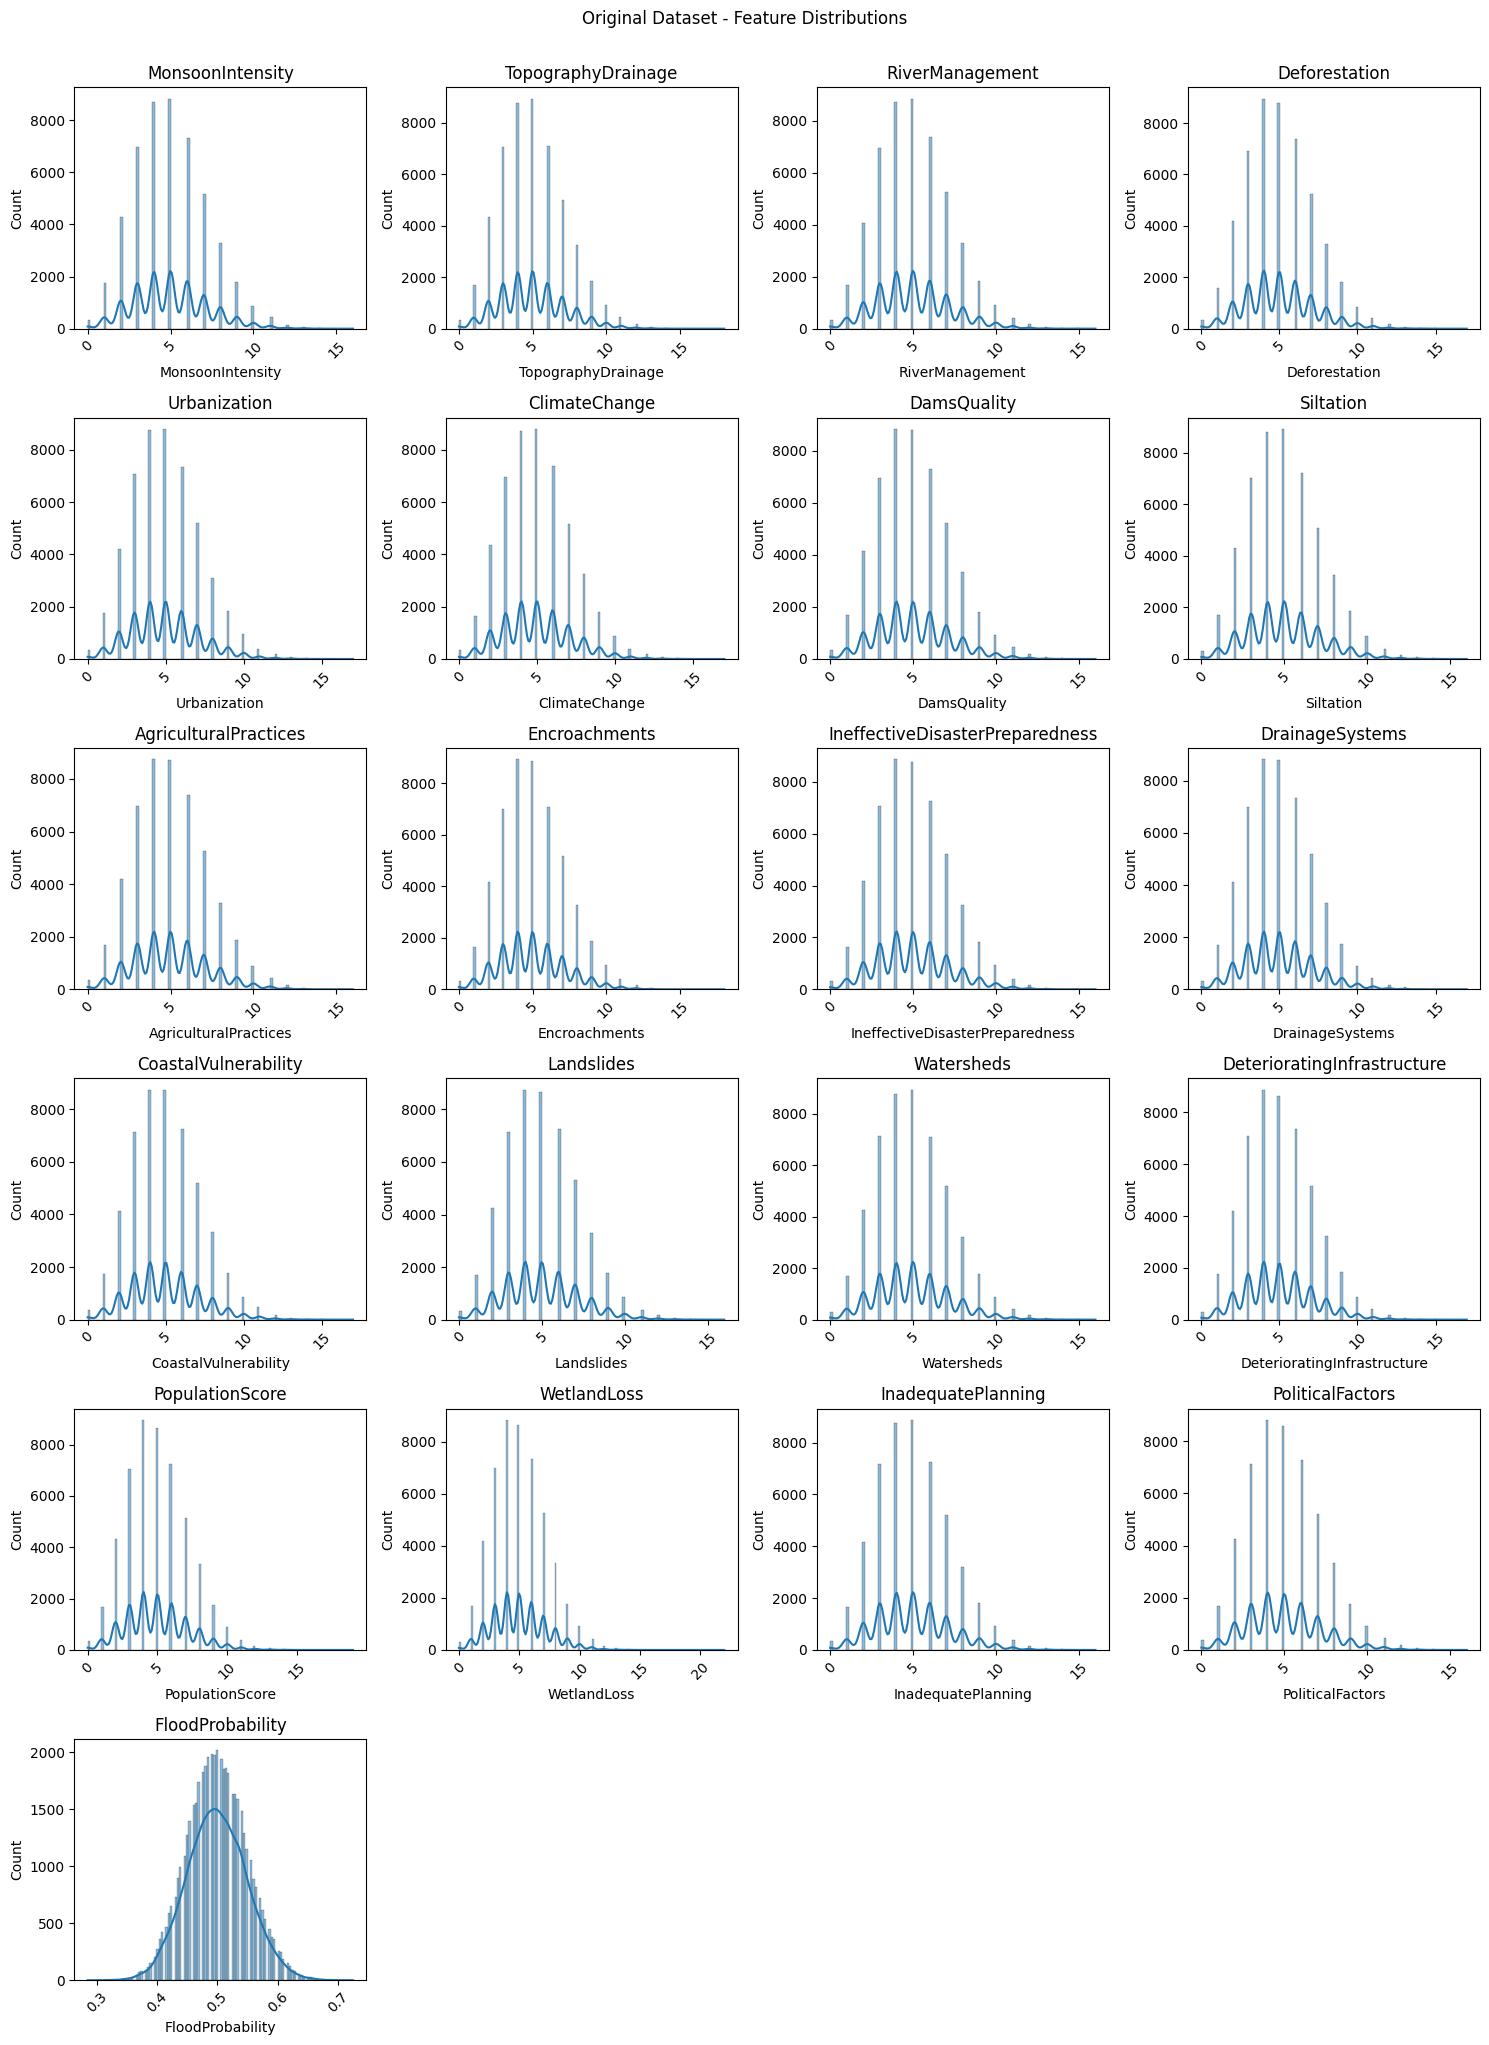

In [19]:
# =============================================
# 2. Explore Original Dataset
# =============================================
print("\n=== 2. Exploring Original Dataset ===")
def explore_dataset(data, dataset_name="Original"):
    print(f"\n{dataset_name} Dataset Overview:")
    print(f"Shape: {data.shape}")
    print("\nFirst 5 rows:")
    display(data.head())

    # Missing values
    print("\nMissing Values:")
    missing = data.isnull().sum()
    print(missing)

    plt.figure(figsize=(10,6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title(f'{dataset_name} Dataset - Missing Values Heatmap')
    plt.show()

    # Data types
    print("\nData Types:")
    print(data.dtypes)

    # Basic statistics
    print("\nDescriptive Statistics:")
    display(data.describe())

    # Visualize distributions
    num_cols = data.select_dtypes(include=np.number).columns
    plt.figure(figsize=(15, 20))
    for i, col in enumerate(num_cols):
        plt.subplot(6, 4, i+1)
        sns.histplot(data[col], kde=True)
        plt.title(col)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.suptitle(f'{dataset_name} Dataset - Feature Distributions', y=1.02)
    plt.show()

explore_dataset(original_data)

In [20]:
# =============================================
# 3. Handle Missing Values in Original Dataset
# =============================================
print("\n=== 3. Handling Missing Values in Original Dataset ===")
def handle_missing_values(data):
    df = data.copy()

    # Track missing values before
    missing_before = df.isnull().sum().sum()

    # Strategy 1: Simple Imputation (Mean/Median/Mode)
    print("\nPerforming Simple Imputation...")
    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = df.select_dtypes(exclude=np.number).columns

    # Numeric - mean imputation
    num_imputer = SimpleImputer(strategy='mean')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

    # Categorical - mode imputation
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

    # Strategy 2: Iterative Imputation (Predictive)
    print("\nPerforming Iterative Imputation...")
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(),
                                       random_state=42)
    df[num_cols] = iterative_imputer.fit_transform(df[num_cols])

    # Verify no missing values remain
    missing_after = df.isnull().sum().sum()
    print(f"\nMissing values before: {missing_before}")
    print(f"Missing values after: {missing_after}")

    return df

original_processed = handle_missing_values(original_data)


=== 3. Handling Missing Values in Original Dataset ===

Performing Simple Imputation...

Performing Iterative Imputation...

Missing values before: 0
Missing values after: 0



=== 4. Generating Synthetic Dataset ===

Generating synthetic data matching South Sudan's characteristics...

Synthetic dataset saved to data/flood_synthetic.csv

Synthetic Dataset Overview:
Shape: (2000, 21)

First 5 rows:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,5.693089,5.868761,6.416324,6.504179,4.860860,4.978983,2.482211,5.529933,0.713448,4.249271,...,9.835938,1.629910,3.473490,4.576967,5.040983,8.159548,6.611522,6.579425,5.228047,0.501080
1,8.112261,0.653607,4.392272,4.940236,4.471240,8.785774,7.852005,5.711429,6.471829,3.217140,...,2.638973,4.952776,0.014647,7.011970,2.455374,1.827636,0.558579,6.352126,4.025622,0.477748
2,4.217831,4.357592,4.662711,12.267145,4.674651,2.782206,8.229277,1.660863,2.118355,3.364871,...,8.140857,0.000000,4.180187,1.643600,5.397863,13.048191,7.541687,8.466658,10.885075,0.550281
3,8.958352,6.882737,4.605705,11.810189,6.400799,4.845374,3.392718,7.575262,2.858119,3.766157,...,5.497891,3.835550,2.478610,5.721855,3.119067,4.594436,4.978611,2.825255,4.746004,0.549227
4,11.147107,4.874253,3.128981,4.003105,4.467092,1.484245,5.450149,6.831031,0.515194,9.828501,...,6.811707,5.519068,3.012741,1.062841,7.059350,6.637827,7.910084,4.475692,3.634450,0.559991



Missing Values:
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64


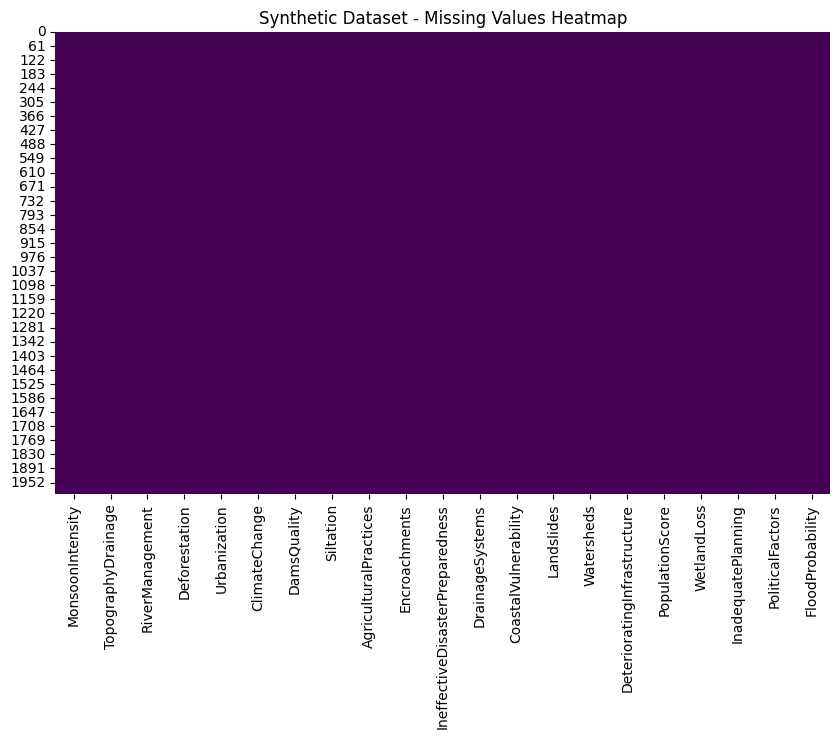


Data Types:
MonsoonIntensity                   float64
TopographyDrainage                 float64
RiverManagement                    float64
Deforestation                      float64
Urbanization                       float64
ClimateChange                      float64
DamsQuality                        float64
Siltation                          float64
AgriculturalPractices              float64
Encroachments                      float64
IneffectiveDisasterPreparedness    float64
DrainageSystems                    float64
CoastalVulnerability               float64
Landslides                         float64
Watersheds                         float64
DeterioratingInfrastructure        float64
PopulationScore                    float64
WetlandLoss                        float64
InadequatePlanning                 float64
PoliticalFactors                   float64
FloodProbability                   float64
dtype: object

Descriptive Statistics:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,5.630374,4.908386,4.950398,6.587053,3.965360,4.996212,5.087214,5.044777,5.078638,4.983272,...,4.985643,5.073384,4.917383,4.994946,4.938927,4.992663,4.963469,4.932143,5.099488,0.500858
std,2.394078,2.237836,2.238869,2.962466,1.714204,2.155540,2.273943,2.207165,2.207921,2.238460,...,2.124968,2.202486,2.223162,2.215397,2.244830,2.282680,2.185042,2.141214,2.193355,0.051460
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.339605
25%,3.979520,3.369096,3.422044,4.531772,2.801818,3.552293,3.489311,3.508459,3.568350,3.427298,...,3.491004,3.539569,3.325271,3.514090,3.366881,3.414795,3.424184,3.440608,3.586063,0.464805
50%,5.584425,4.914164,4.923554,6.531167,3.975205,4.937456,5.103220,5.026337,5.085482,5.003295,...,5.034512,5.067011,4.895770,5.006801,4.907077,4.920134,4.990218,4.959013,5.138943,0.500020
75%,7.181412,6.439698,6.487625,8.604915,5.124084,6.423372,6.638921,6.577013,6.606937,6.506762,...,6.422123,6.569913,6.447830,6.534796,6.510053,6.542603,6.448638,6.408368,6.603221,0.536250
max,13.347326,13.804346,11.961808,16.708462,9.220696,12.509822,12.713264,14.988791,11.925958,13.843640,...,12.026299,12.225189,13.208203,12.467865,12.271268,13.328913,11.744262,12.309463,12.393367,0.676609


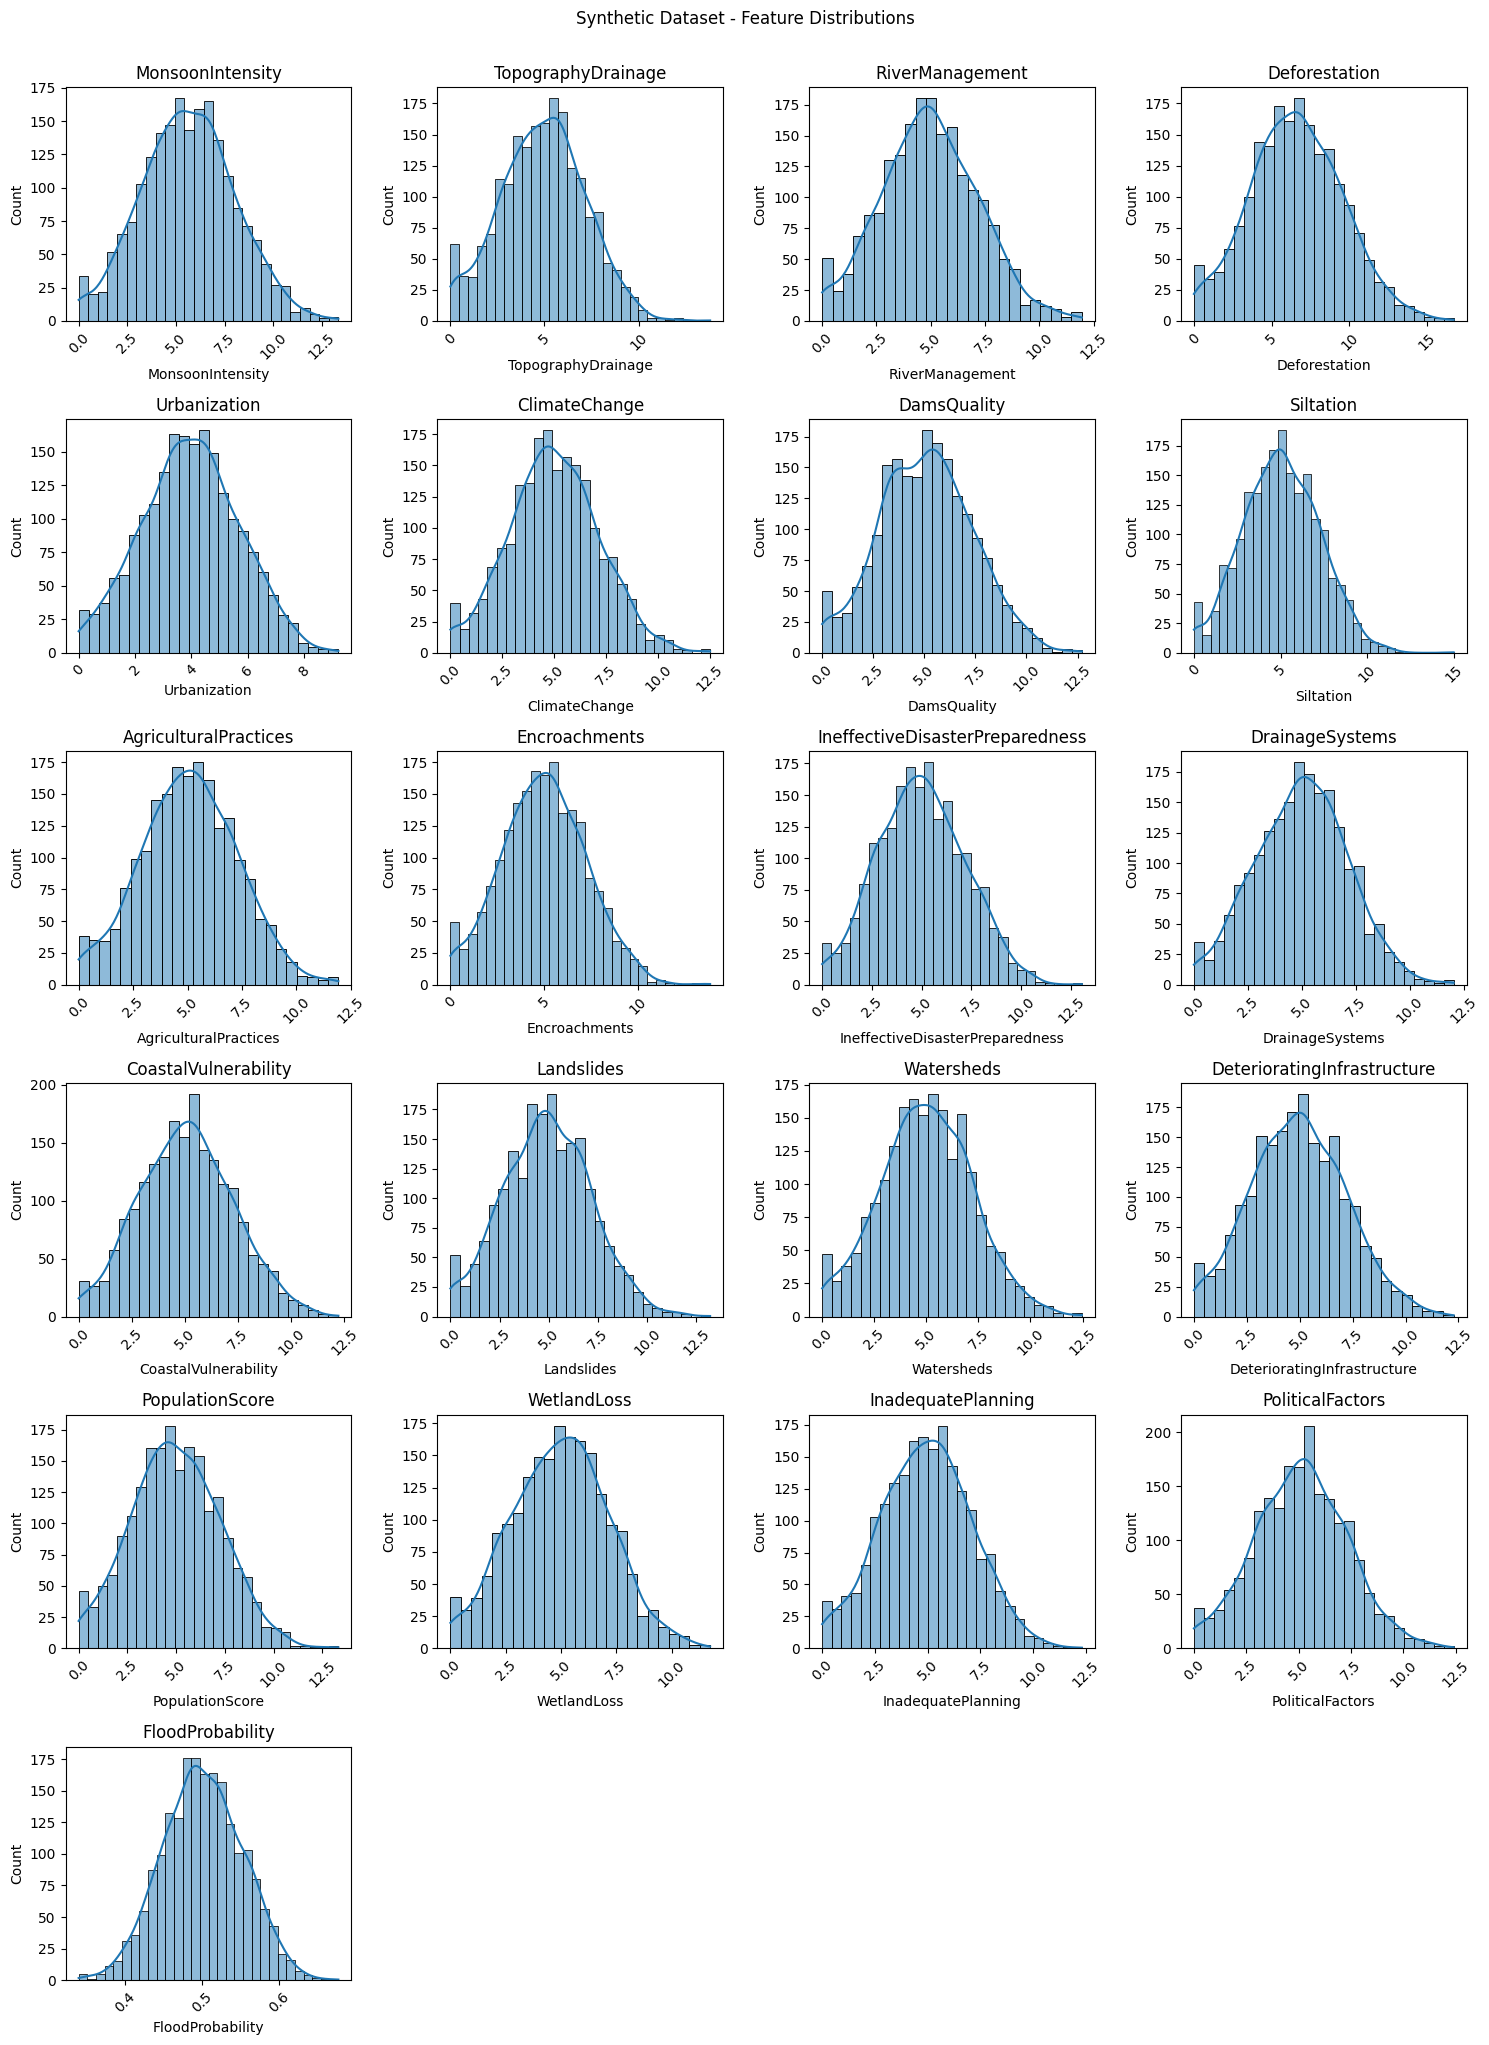

In [21]:
# =============================================
# 4. Generate Synthetic Dataset
# =============================================
print("\n=== 4. Generating Synthetic Dataset ===")
def generate_synthetic_data(original, num_samples=1000):
    print("\nGenerating synthetic data matching South Sudan's characteristics...")
    fake = Faker()

    # Get statistical properties from original data
    stats = original.describe()

    synthetic_data = pd.DataFrame()

    # Generate synthetic samples for each feature
    for col in original.columns:
        if original[col].dtype == 'object':
            # For categorical - random selection from existing values
            synthetic_data[col] = np.random.choice(original[col].dropna(), num_samples)
        else:
            # For numerical - generate within reasonable ranges
            if col in stats.columns:
                mean = stats[col]['mean']
                std = stats[col]['std']
                min_val = max(original[col].min() * 0.8, 0)  # Don't go below 0
                max_val = original[col].max() * 1.2

                # Generate with normal distribution within bounds
                samples = np.random.normal(mean, std, num_samples)
                samples = np.clip(samples, min_val, max_val)
                synthetic_data[col] = samples
            else:
                # If not in stats (e.g., categorical that was encoded)
                synthetic_data[col] = original[col].sample(num_samples, replace=True).values

    # Adjust specific features for South Sudan context
    if 'MonsoonIntensity' in synthetic_data.columns:
        synthetic_data['MonsoonIntensity'] = synthetic_data['MonsoonIntensity'] * 1.1  # Higher monsoon

    if 'Urbanization' in synthetic_data.columns:
        synthetic_data['Urbanization'] = synthetic_data['Urbanization'] * 0.8  # Lower urbanization

    if 'Deforestation' in synthetic_data.columns:
        synthetic_data['Deforestation'] = synthetic_data['Deforestation'] * 1.3  # Higher deforestation

    return synthetic_data

synthetic_data = generate_synthetic_data(original_processed, num_samples=2000)

# Save synthetic dataset
synthetic_path = 'data/flood_synthetic.csv'
synthetic_data.to_csv(synthetic_path, index=False)
print(f"\nSynthetic dataset saved to {synthetic_path}")

# Explore synthetic data
explore_dataset(synthetic_data, "Synthetic")

In [22]:
# =============================================
# 5. Handle Missing Values in Synthetic Dataset
# =============================================
print("\n=== 5. Handling Missing Values in Synthetic Dataset ===")
synthetic_processed = handle_missing_values(synthetic_data)


=== 5. Handling Missing Values in Synthetic Dataset ===

Performing Simple Imputation...

Performing Iterative Imputation...

Missing values before: 0
Missing values after: 0



=== 6. Merging Datasets ===

Merged dataset saved to data/flood_merged.csv

Merged Dataset Overview:
Shape: (52000, 21)

First 5 rows:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3.0,8.0,6.0,6.0,4.0,4.0,6.0,2.0,3.0,2.0,...,10.0,7.0,4.0,2.0,3.0,4.0,3.0,2.0,6.0,0.450
1,8.0,4.0,5.0,7.0,7.0,9.0,1.0,5.0,5.0,4.0,...,9.0,2.0,6.0,2.0,1.0,1.0,9.0,1.0,3.0,0.475
2,3.0,10.0,4.0,1.0,7.0,5.0,4.0,7.0,4.0,9.0,...,7.0,4.0,4.0,8.0,6.0,1.0,8.0,3.0,6.0,0.515
3,4.0,4.0,2.0,7.0,3.0,4.0,1.0,4.0,6.0,4.0,...,4.0,2.0,6.0,6.0,8.0,8.0,6.0,6.0,10.0,0.520
4,3.0,7.0,5.0,2.0,5.0,8.0,5.0,2.0,7.0,5.0,...,7.0,6.0,5.0,3.0,3.0,4.0,4.0,3.0,4.0,0.475



Missing Values:
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64


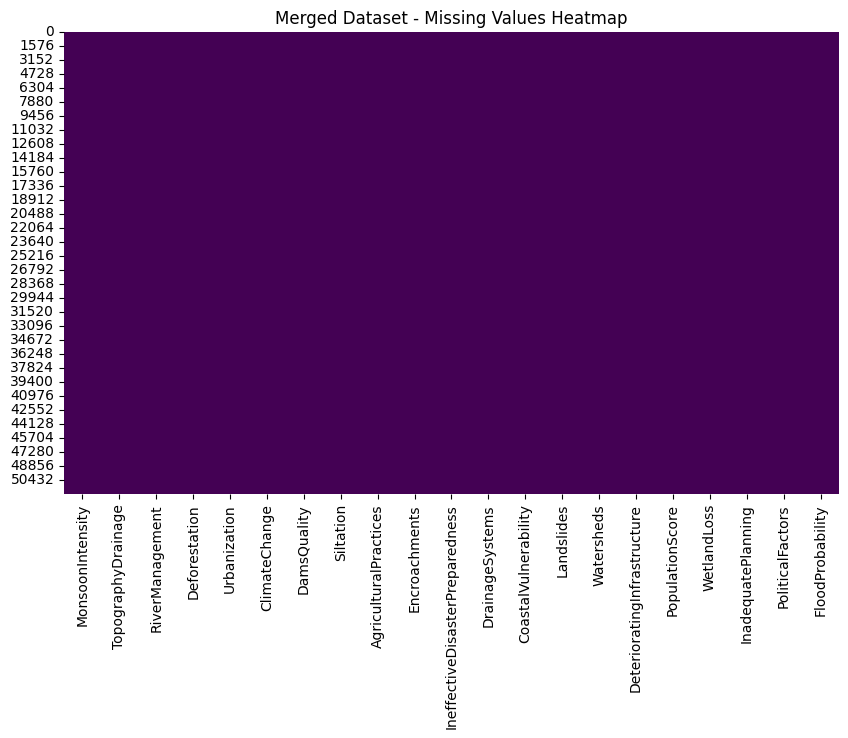


Data Types:
MonsoonIntensity                   float64
TopographyDrainage                 float64
RiverManagement                    float64
Deforestation                      float64
Urbanization                       float64
ClimateChange                      float64
DamsQuality                        float64
Siltation                          float64
AgriculturalPractices              float64
Encroachments                      float64
IneffectiveDisasterPreparedness    float64
DrainageSystems                    float64
CoastalVulnerability               float64
Landslides                         float64
Watersheds                         float64
DeterioratingInfrastructure        float64
PopulationScore                    float64
WetlandLoss                        float64
InadequatePlanning                 float64
PoliticalFactors                   float64
FloodProbability                   float64
dtype: object

Descriptive Statistics:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,...,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000
mean,5.016053,4.981188,5.013419,5.069194,4.949687,4.988643,5.018124,4.990761,5.008909,5.005491,...,5.005275,5.002746,4.981649,4.980402,4.986305,4.985275,5.003518,4.991967,4.994711,0.499706
std,2.246424,2.246182,2.231615,2.275984,2.233819,2.224044,2.246140,2.231673,2.233591,2.241494,...,2.233846,2.245425,2.227581,2.231527,2.231661,2.239982,2.229975,2.226673,2.244147,0.050090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.465000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.500000
75%,6.000000,6.000000,6.000000,6.013176,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,0.535000
max,16.000000,18.000000,16.000000,17.000000,17.000000,17.000000,16.000000,16.000000,16.000000,18.000000,...,17.000000,17.000000,16.000000,16.000000,17.000000,19.000000,22.000000,16.000000,16.000000,0.725000


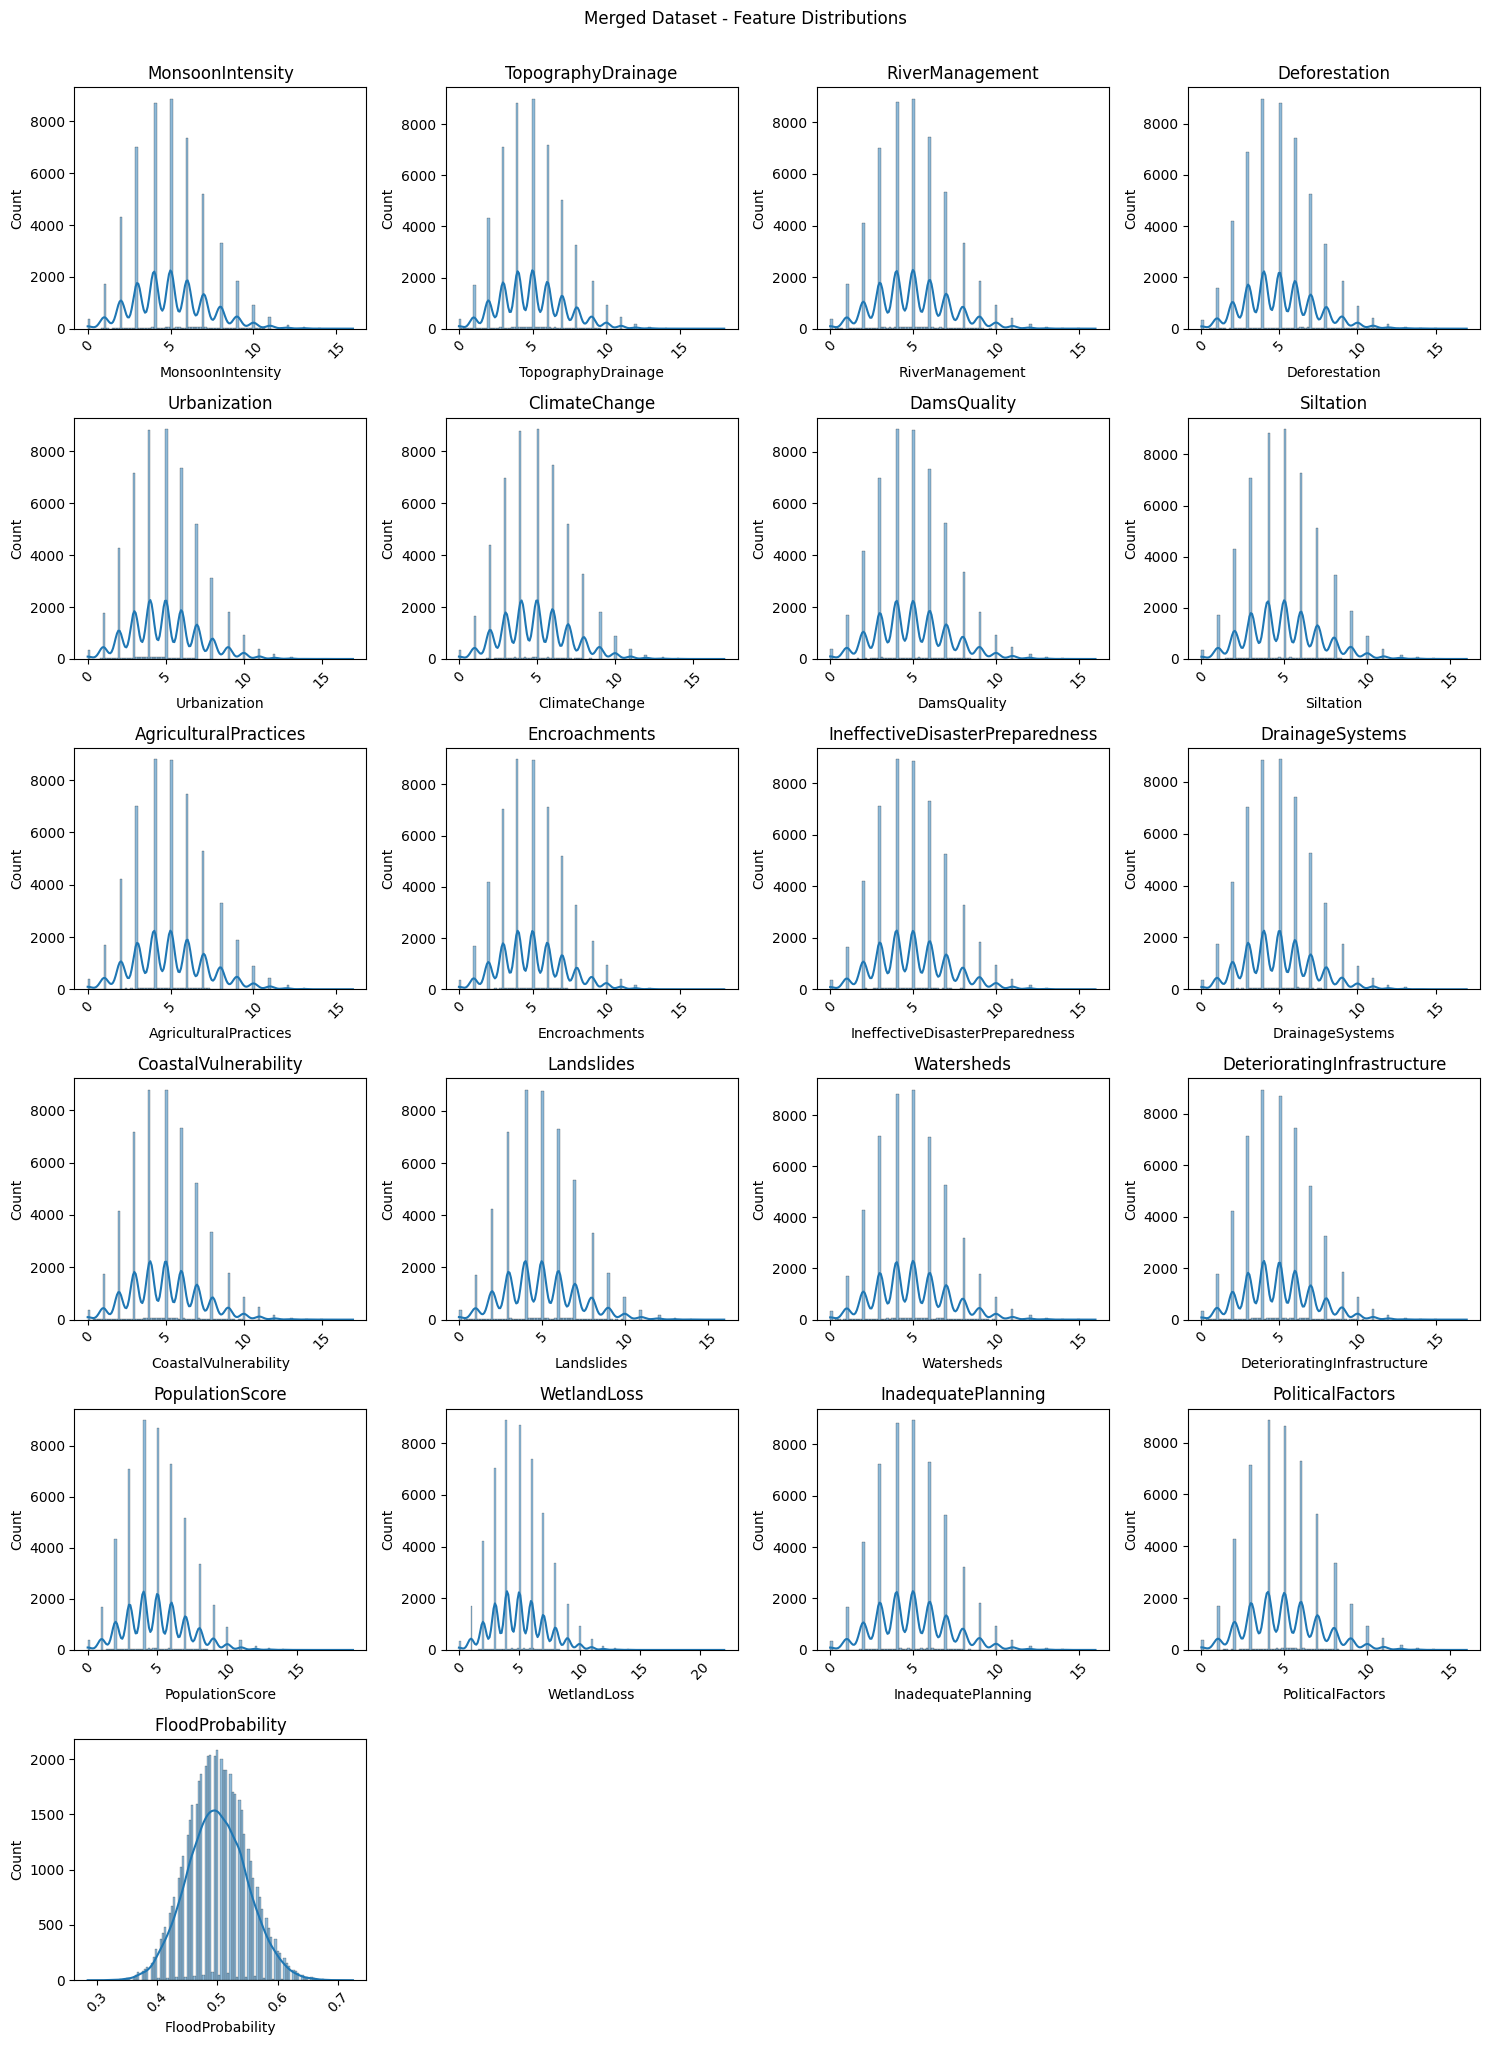

In [23]:
# =============================================
# 6. Merge Original and Synthetic Datasets
# =============================================
print("\n=== 6. Merging Datasets ===")
merged_data = pd.concat([original_processed, synthetic_processed], ignore_index=True)

# Save merged dataset
merged_path = 'data/flood_merged.csv'
merged_data.to_csv(merged_path, index=False)
print(f"\nMerged dataset saved to {merged_path}")

# Explore merged data
explore_dataset(merged_data, "Merged")

In [24]:
# =============================================
# 7. Handle Missing Values in Merged Dataset
# =============================================
print("\n=== 7. Handling Missing Values in Merged Dataset ===")
merged_processed = handle_missing_values(merged_data)


=== 7. Handling Missing Values in Merged Dataset ===

Performing Simple Imputation...

Performing Iterative Imputation...

Missing values before: 0
Missing values after: 0


In [25]:
# =============================================
# 8. Remove Duplicates
# =============================================
print("\n=== 8. Removing Duplicates ===")
before_shape = merged_processed.shape
merged_processed = merged_processed.drop_duplicates()
after_shape = merged_processed.shape

print(f"Rows before: {before_shape[0]}, after: {after_shape[0]}")
print(f"Removed {before_shape[0] - after_shape[0]} duplicate rows")


=== 8. Removing Duplicates ===
Rows before: 52000, after: 52000
Removed 0 duplicate rows



=== 9. Post-Merge Visualization ===


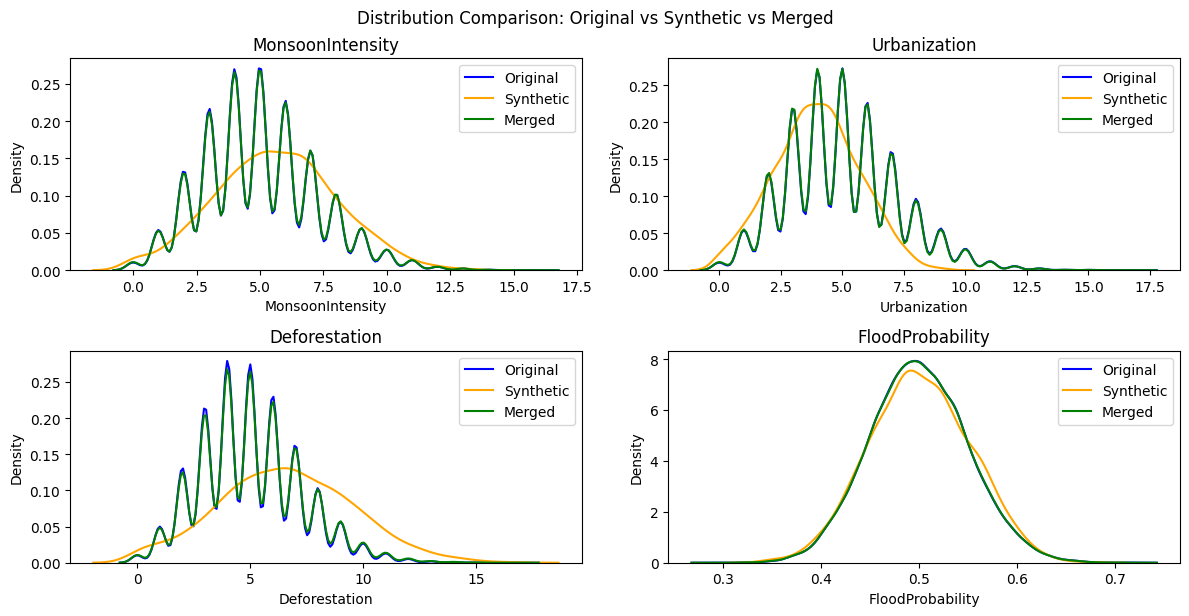

In [26]:
# =============================================
# 9. Data Visualization Post-Merging
# =============================================
print("\n=== 9. Post-Merge Visualization ===")
plt.figure(figsize=(12, 6))

# Compare distributions of key features
key_features = ['MonsoonIntensity', 'Urbanization', 'Deforestation', 'FloodProbability']
for i, feature in enumerate(key_features):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(original_processed[feature], label='Original', color='blue')
    sns.kdeplot(synthetic_processed[feature], label='Synthetic', color='orange')
    sns.kdeplot(merged_processed[feature], label='Merged', color='green')
    plt.title(feature)
    plt.legend()

plt.tight_layout()
plt.suptitle('Distribution Comparison: Original vs Synthetic vs Merged', y=1.02)
plt.show()

In [27]:
# =============================================
# 10. Statistical Summarization
# =============================================
print("\n=== 10. Statistical Summarization ===")
print("\nDescriptive Statistics for Merged Dataset:")
display(merged_processed.describe())

# Generate detailed report
def generate_stat_report(data):
    report = pd.DataFrame({
        'Feature': data.columns,
        'Mean': data.mean(),
        'Median': data.median(),
        'Std': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis()
    })
    return report

stat_report = generate_stat_report(merged_processed.select_dtypes(include=np.number))
print("\nDetailed Statistical Report:")
display(stat_report)


=== 10. Statistical Summarization ===

Descriptive Statistics for Merged Dataset:


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
count,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,...,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000,52000.000000
mean,5.016053,4.981188,5.013419,5.069194,4.949687,4.988643,5.018124,4.990761,5.008909,5.005491,...,5.005275,5.002746,4.981649,4.980402,4.986305,4.985275,5.003518,4.991967,4.994711,0.499706
std,2.246424,2.246182,2.231615,2.275984,2.233819,2.224044,2.246140,2.231673,2.233591,2.241494,...,2.233846,2.245425,2.227581,2.231527,2.231661,2.239982,2.229975,2.226673,2.244147,0.050090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,0.465000
50%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.500000
75%,6.000000,6.000000,6.000000,6.013176,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,0.535000
max,16.000000,18.000000,16.000000,17.000000,17.000000,17.000000,16.000000,16.000000,16.000000,18.000000,...,17.000000,17.000000,16.000000,16.000000,17.000000,19.000000,22.000000,16.000000,16.000000,0.725000



Detailed Statistical Report:


,Feature,Mean,Median,Std,Min,Max,Skewness,Kurtosis
MonsoonIntensity,MonsoonIntensity,5.016053,5.0,2.246424,0.000,16.000,0.421825,0.127472
TopographyDrainage,TopographyDrainage,4.981188,5.0,2.246182,0.000,18.000,0.450899,0.191330
RiverManagement,RiverManagement,5.013419,5.0,2.231615,0.000,16.000,0.420623,0.177584
Deforestation,Deforestation,5.069194,5.0,2.275984,0.000,17.000,0.484316,0.322287
Urbanization,Urbanization,4.949687,5.0,2.233819,0.000,17.000,0.479464,0.318508
ClimateChange,ClimateChange,4.988643,5.0,2.224044,0.000,17.000,0.431933,0.195197
DamsQuality,DamsQuality,5.018124,5.0,2.246140,0.000,16.000,0.429676,0.155679
Siltation,Siltation,4.990761,5.0,2.231673,0.000,16.000,0.445850,0.200222
AgriculturalPractices,AgriculturalPractices,5.008909,5.0,2.233591,0.000,16.000,0.411449,0.133920
Encroachments,Encroachments,5.005491,5.0,2.241494,0.000,18.000,0.445489,0.195102



=== 11. Feature Selection ===

Correlation Analysis:


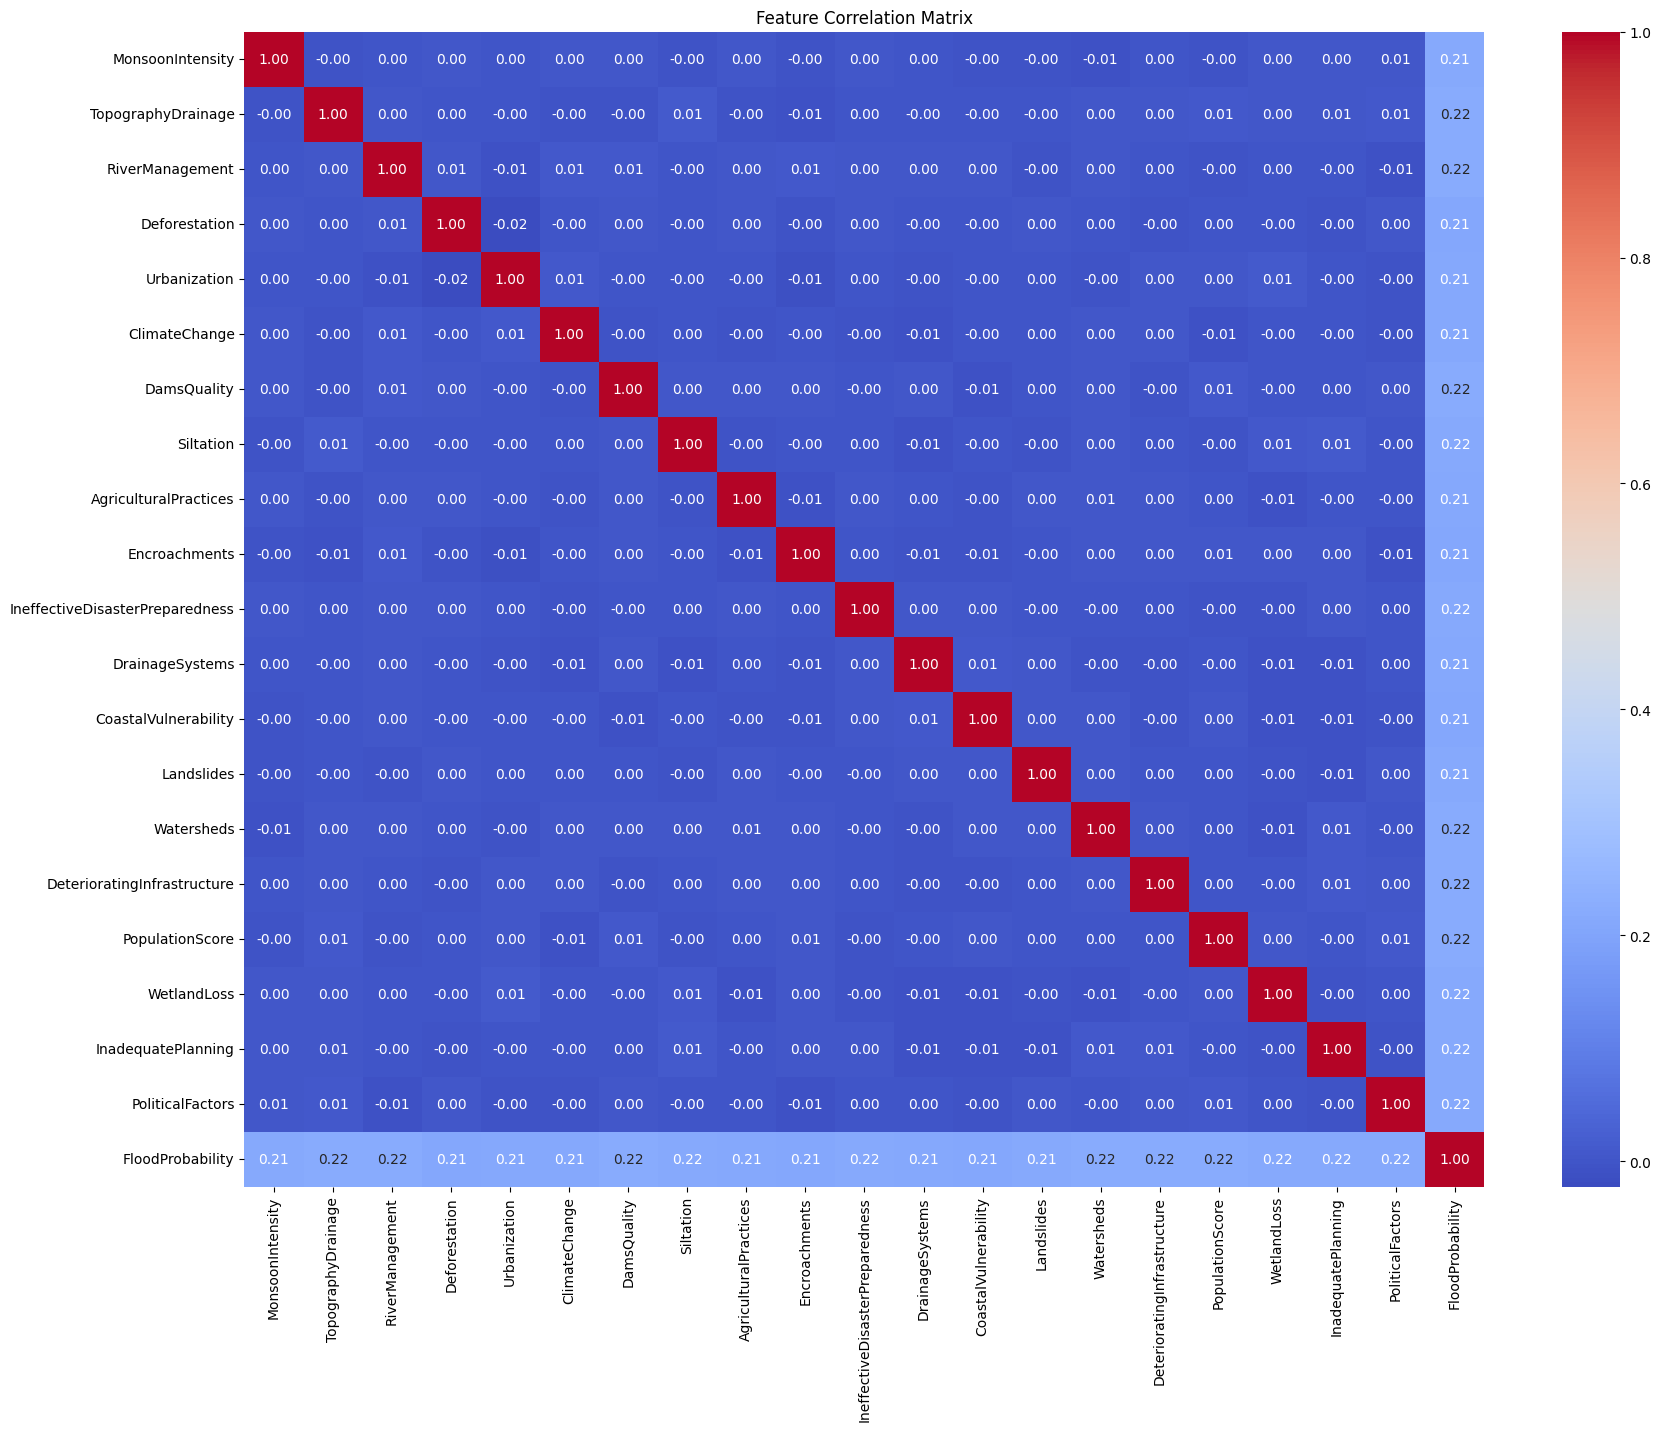


Top 18 features correlated with target:
['DeterioratingInfrastructure', 'Watersheds', 'RiverManagement', 'TopographyDrainage', 'DamsQuality', 'PopulationScore', 'IneffectiveDisasterPreparedness', 'InadequatePlanning', 'Siltation', 'PoliticalFactors', 'WetlandLoss', 'MonsoonIntensity', 'Landslides', 'AgriculturalPractices', 'ClimateChange', 'Urbanization', 'DrainageSystems', 'Encroachments']

Statistical Feature Selection (ANOVA F-value):

Top 18 features selected by ANOVA F-value:
['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']

Final processed dataset saved to data/flood_processed.csv


In [28]:
# =============================================
# 11. Feature Selection
# =============================================
print("\n=== 11. Feature Selection ===")

def select_features(data, target_col='FloodProbability', k=30):
    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Remove specific features if present
    if 'DamsQuality' in X.columns:
        X = X.drop(columns=['DamsQuality'])
    if 'Watersheds' in X.columns:
        X = X.drop(columns=['Watersheds'])

    # Update `k` if it exceeds available features
    available_features = X.shape[1]
    if k > available_features:
        print(f"Warning: k={k} exceeds available features ({available_features}). Using k={available_features} instead.")
        k = available_features

    # 1. Correlation Analysis
    print("\nCorrelation Analysis:")
    plt.figure(figsize=(20, 15))
    corr_matrix = data.corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    plt.show()

    # Get top correlated features with target
    corr_with_target = corr_matrix[target_col].abs().sort_values(ascending=False)
    top_corr_features = corr_with_target[1:k+1].index.tolist()  # Exclude target itself
    print(f"\nTop {k} features correlated with target:")
    print(top_corr_features)

    # 2. Statistical Feature Selection (ANOVA F-value)
    print("\nStatistical Feature Selection (ANOVA F-value):")
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)

    # Get selected feature names
    mask = selector.get_support()
    selected_features = X.columns[mask].tolist()
    print(f"\nTop {k} features selected by ANOVA F-value:")
    print(selected_features)

    # Combine both methods (union of features)
    final_features = list(set(top_corr_features + selected_features))

    # Add target back
    final_features.append(target_col)

    return data[final_features]

# Run feature selection
selected_data = select_features(merged_processed, k=30)

# Save final processed dataset
final_path = 'data/flood_processed.csv'
selected_data.to_csv(final_path, index=False)
print(f"\nFinal processed dataset saved to {final_path}")


In [29]:
# =============================================
# 12. Prepare Data for Modeling
# =============================================
print("\n=== 12. Preparing Data for Modeling ===")
def prepare_data(data):
    # Encode FloodRisk based on FloodProbability
    data['FloodRisk'] = pd.cut(
        data['FloodProbability'],
        bins=[0, 0.4, 0.6, 1],
        labels=['Low', 'Medium', 'High']
    )
    data['FloodRisk'] = data['FloodRisk'].map({'Low': 0, 'Medium': 1, 'High': 2}).astype(int)

    # Handle class imbalance
    majority_class = data[data['FloodRisk'] == 0]
    medium_class = data[data['FloodRisk'] == 1]
    minority_class = data[data['FloodRisk'] == 2]

    minority_upsampled = resample(minority_class, replace=True,
                                 n_samples=len(majority_class), random_state=42)
    medium_upsampled = resample(medium_class, replace=True,
                               n_samples=len(majority_class), random_state=42)
    balanced_data = pd.concat([majority_class, medium_upsampled, minority_upsampled])

    # Split features and target
    X = balanced_data.drop(['FloodRisk', 'FloodProbability'], axis=1)
    y = balanced_data['FloodRisk']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save the scaler
    joblib.dump(scaler, 'models/scaler.pkl')

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, X.columns.tolist()

X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names = prepare_data(selected_data)


=== 12. Preparing Data for Modeling ===


/var/folders/8h/ck7w0mcd0w9805v5lldfp39r0000gn/T/ipykernel_3253/3449835804.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FloodRisk'] = pd.cut(
/var/folders/8h/ck7w0mcd0w9805v5lldfp39r0000gn/T/ipykernel_3253/3449835804.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['FloodRisk'] = data['FloodRisk'].map({'Low': 0, 'Medium': 1, 'High': 2}).astype(int)


In [30]:
# =============================================
# 12.1 Save Train/Test Data
# =============================================
print("\n=== 12.1 Saving Train/Test Data ===")
def save_train_test_data(X_train, X_test, y_train, y_test, feature_names):
    # Convert back to DataFrames for easier saving
    train_df = pd.DataFrame(X_train, columns=feature_names)
    train_df['FloodRisk'] = y_train.values
    
    test_df = pd.DataFrame(X_test, columns=feature_names)
    test_df['FloodRisk'] = y_test.values
    
    # Save to CSV
    train_df.to_csv('data/train_data.csv', index=False)
    test_df.to_csv('data/test_data.csv', index=False)
    print("Train and test data saved to data/ directory")

save_train_test_data(X_train_scaled, X_test_scaled, y_train, y_test, feature_names)


=== 12.1 Saving Train/Test Data ===
Train and test data saved to data/ directory


In [31]:
%pip install pydot graphviz
# =============================================
# 13. Neural Network Model Definition (Debugged Version)
# =============================================
def define_nn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(6, activation='relu'),
        Dense(3, activation='softmax')
    ])

    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Ensure model visualization file is saved correctly
    model_plot_path = 'model_architecture.png'
    plot_model(model, to_file=model_plot_path, show_shapes=True)
    
    if os.path.exists(model_plot_path):
        display(Image(filename=model_plot_path))
    else:
        print("Warning: Model visualization file was not created.")
    
    return model

model = define_nn_model((X_train_scaled.shape[1],))

Note: you may need to restart the kernel to use updated packages.
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.



=== 14. Training Model ===
Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5372 - loss: 1.1925 - val_accuracy: 0.8099 - val_loss: 0.6892
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7930 - loss: 0.7389 - val_accuracy: 0.9137 - val_loss: 0.5016
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8694 - loss: 0.5876 - val_accuracy: 0.9243 - val_loss: 0.4313
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8847 - loss: 0.4964 - val_accuracy: 0.9419 - val_loss: 0.3760
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9044 - loss: 0.4429 - val_accuracy: 0.9454 - val_loss: 0.3385
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9042 - loss: 0.4213 - val_accuracy: 0.9437 - val_loss: 0.3157
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9274 - loss: 0.3690 - val_accuracy: 0.9454 - val_loss: 0.2943
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9242 - loss: 0.34

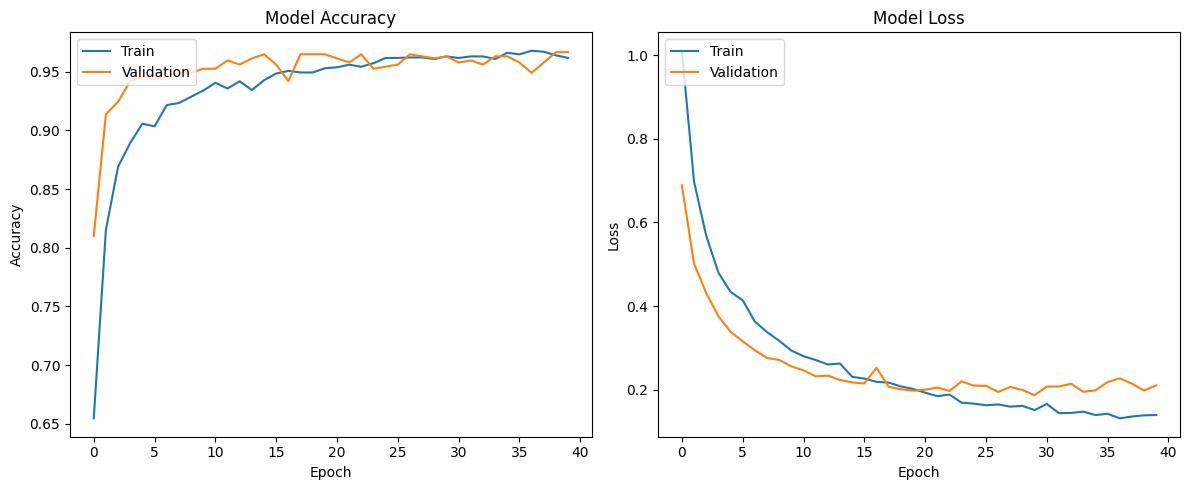


Model saved as 'models/flood_risk.pkl'


In [32]:
# =============================================
# 14. Model Training
# =============================================
print("\n=== 14. Training Model ===")
def train_nn_model(model, X_train, y_train, epochs=100, batch_size=32):
    # Create validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Visualize training process
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

    # Save the trained model in .pkl format
    with open('models/flood_risk.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("\nModel saved as 'models/flood_risk.pkl'")

    return model, history

model, history = train_nn_model(model, X_train_scaled, y_train)


=== 15. Evaluating Model ===
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.9563
ROC AUC Score: 0.9848

Classification Report:
              precision    recall  f1-score   support

         Low       0.97      0.97      0.97       236
      Medium       0.92      0.96      0.94       237
        High       0.98      0.95      0.96       237

    accuracy                           0.96       710
   macro avg       0.96      0.96      0.96       710
weighted avg       0.96      0.96      0.96       710



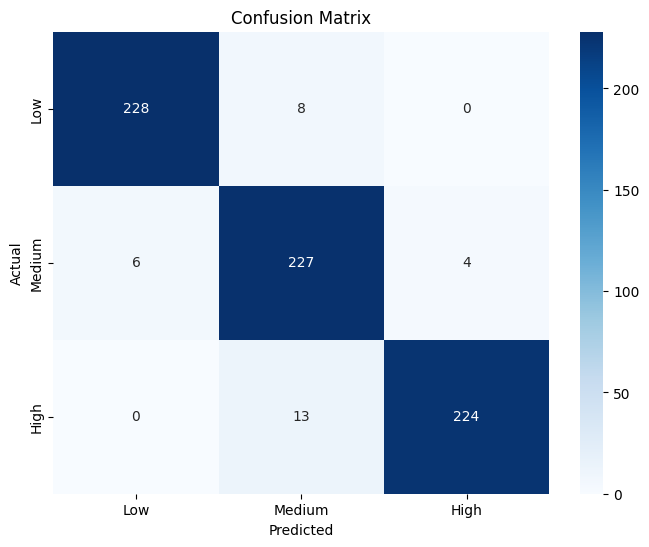

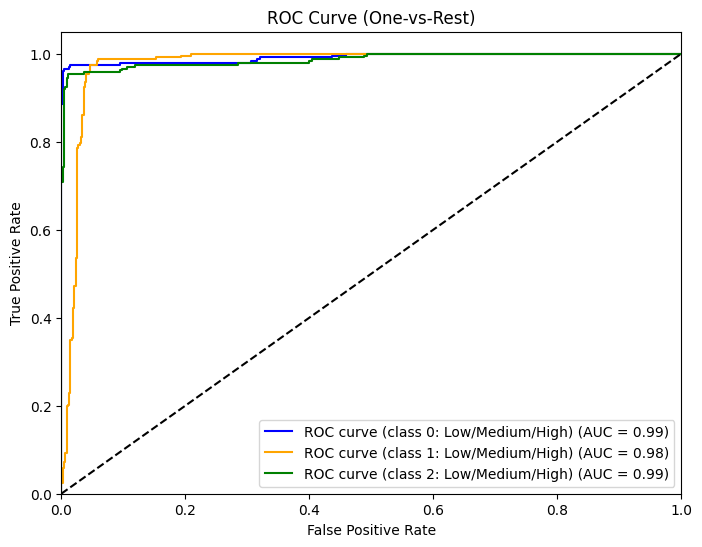

In [33]:
# =============================================
# 15. Model Evaluation
# =============================================
print("\n=== 15. Evaluating Model ===")
def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    # Print metrics
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"ROC AUC Score: {metrics['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

    # Confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'orange', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'ROC curve (class {i}: Low/Medium/High) (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()

    return metrics

metrics = evaluate_model(model, X_test_scaled, y_test)


=== 15.1 Calculating Feature Importance ===

Calculating permutation importance...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


2025-03-31 20:37:09.842579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-31 20:37:09.842589: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-31 20:37:09.842577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-31 20:37:09.842604: I tensorflow/core/platform/cpu_featu

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
23/23 ━━

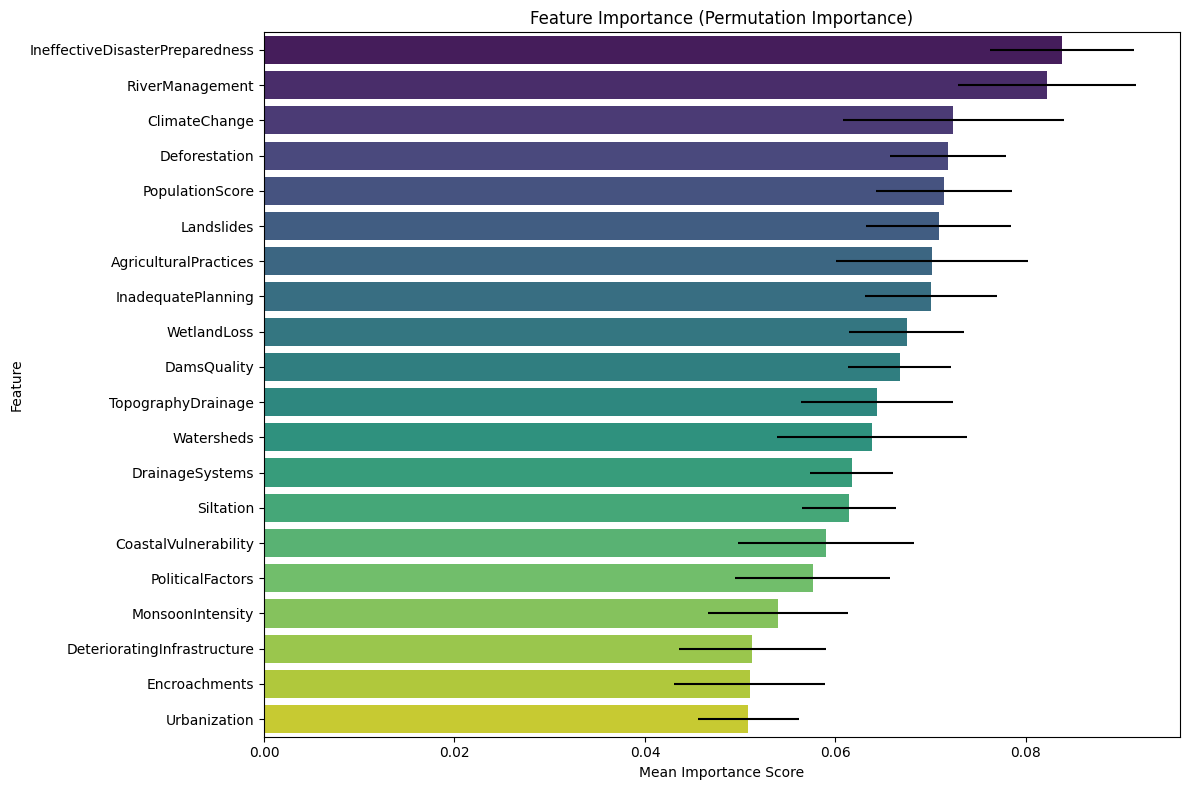

In [36]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

# =============================================
# 15.1 Calculate and Save Feature Importance
# =============================================
print("\n=== 15.1 Calculating Feature Importance ===")

def calculate_and_save_feature_importance(model, X_test, y_test, feature_names):
    print("\nCalculating permutation importance...")

    # Ensure the model is fitted before calculating permutation importance
    if not hasattr(model, "predict"):
        raise ValueError("Error: The provided model does not have a 'predict' method. Ensure it is a trained model.")

    # Custom scoring function for classification
    def custom_score(model, X, y):
        y_pred = model.predict(X)
        y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
        return accuracy_score(y, y_pred_classes)

    # Compute permutation importance
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1,
        scoring=custom_score  # Use custom scoring function
    )

    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values('importance_mean', ascending=False)

    # Save to CSV
    importance_df.to_csv('data/feature_importance.csv', index=False)
    print("Feature importance saved to data/feature_importance.csv")

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance_mean', y='feature', data=importance_df, 
                xerr=importance_df['importance_std'], palette="viridis")
    plt.title('Feature Importance (Permutation Importance)')
    plt.xlabel('Mean Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    return importance_df

# Call the function (Ensure model is trained before this step)
feature_importance = calculate_and_save_feature_importance(
    model, X_test_scaled, y_test, feature_names
)

In [38]:
# =============================================
# 16. Prediction Function
# =============================================
print("\n=== 16. Creating Prediction Function ===")
def predict_risk(input_data, model_path='models/flood_risk.pkl', scaler_path='models/scaler.pkl'):
    # Load model and scaler
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    scaler = joblib.load(scaler_path)

    # Convert input to DataFrame if it's a dictionary
    if isinstance(input_data, dict):
        input_data = pd.DataFrame([input_data])

    # Store original data for display
    original_data = input_data.copy()

    # Preprocess input data
    if 'FloodProbability' in input_data.columns:
        input_data = input_data.drop('FloodProbability', axis=1)

    # Scale features
    input_scaled = scaler.transform(input_data)

    # Make predictions
    probabilities = model.predict(input_scaled)
    predicted_class = np.argmax(probabilities, axis=1)
    class_labels = ['Low', 'Medium', 'High']
    predictions = [class_labels[c] for c in predicted_class]

    # Visualize prediction probabilities
    plt.figure(figsize=(10, 5))
    for i, prob in enumerate(probabilities):
        plt.subplot(1, len(probabilities), i+1)
        plt.bar(['Low', 'Medium', 'High'], prob, color=['blue', 'orange', 'green'])
        plt.title(f'Prediction Probabilities (Sample {i+1})')
        plt.xlabel('Flood Risk')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # Prepare results
    results = []
    for i in range(len(predictions)):
        result = {
            'input_features': original_data.iloc[i].to_dict(),
            'prediction': predictions[i],
            'probabilities': {
                'Low': float(probabilities[i][0]),
                'Medium': float(probabilities[i][1]),
                'High': float(probabilities[i][2])
            }
        }
        results.append(result)

    return results[0] if len(results) == 1 else results


=== 16. Creating Prediction Function ===



Sample Prediction Input Features:


,Deforestation,PoliticalFactors,Landslides,DeterioratingInfrastructure,AgriculturalPractices,ClimateChange,IneffectiveDisasterPreparedness,Watersheds,PopulationScore,CoastalVulnerability,InadequatePlanning,DrainageSystems,RiverManagement,Urbanization,DamsQuality,Encroachments,Siltation,WetlandLoss,MonsoonIntensity,TopographyDrainage
0,2.467978,-1.661349,-0.83867,1.258023,1.699944,-1.248217,0.400341,0.408518,1.701614,-0.850532,-0.822593,1.236432,0.818461,2.548206,-0.010007,-0.864609,0.008804,-0.012944,2.882925,1.288829



Prediction Result:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


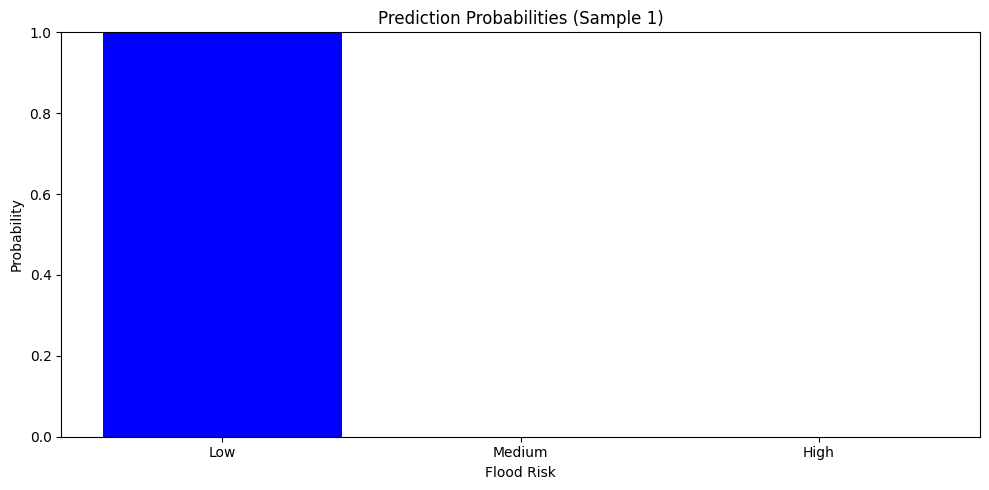

{'input_features': {'Deforestation': 2.4679784720591704, 'PoliticalFactors': -1.6613491948492298, 'Landslides': -0.8386695641628681, 'DeterioratingInfrastructure': 1.25802260659461, 'AgriculturalPractices': 1.6999435166849404, 'ClimateChange': -1.2482166844807767, 'IneffectiveDisasterPreparedness': 0.40034053439046613, 'Watersheds': 0.4085182436079617, 'PopulationScore': 1.7016136449733557, 'CoastalVulnerability': -0.8505317136201982, 'InadequatePlanning': -0.8225930654667627, 'DrainageSystems': 1.2364317096051307, 'RiverManagement': 0.818460628382904, 'Urbanization': 2.5482064103509985, 'DamsQuality': -0.010006562564323694, 'Encroachments': -0.8646088827709466, 'Siltation': 0.008804294288673149, 'WetlandLoss': -0.012943841586677373, 'MonsoonIntensity': 2.8829248136891175, 'TopographyDrainage': 1.2888287899149409}, 'prediction': 'Low', 'probabilities': {'Low': 1.0, 'Medium': 2.991037092663917e-28, 'High': 0.0}}


In [39]:
# Demo prediction
sample_input = pd.DataFrame([X_test_scaled[0]], columns=feature_names)
print("\nSample Prediction Input Features:")
display(sample_input)
print("\nPrediction Result:")
print(predict_risk(sample_input))